In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import itertools

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns
importlib.reload(sys.modules['create_spectrum'])
importlib.reload(sys.modules['reformat_columns'])
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns


In [2]:
QUERY_DIR = '../../data/mod_cosine_queries/'
QUERY_PATH = 's3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/'
DATA_DIR = '../../data/'

UNWEIGHTED_FILE = 'filtered_10_ppm'
WEIGHTED_FILE = 'weighted_filtered_10_ppm'


# Get queries

In [3]:
# Get the NIST23 queries
# queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
queries = pd.read_csv(f'{QUERY_DIR}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
weighted_queries = pd.read_csv(f'{QUERY_DIR}{WEIGHTED_FILE}_with_stats.csv', index_col=0)
print(queries.shape), print(weighted_queries.shape)

# Filter the queries to only include queries in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(weighted_queries['wout_identifier'])]
weighted_queries = weighted_queries[weighted_queries['wout_identifier'].isin(queries['wout_identifier'])]

(25437, 13)
(25437, 13)


In [4]:
# Reformat columns in the query dataframe
queries = reformat_columns(['library_spectra_matches', 
                            'exact_matches', 
                            'nist_inchis', 
                            'smiles', 
                            'tanimoto'],
                            query_type='modified_cosine',
                            query_df=queries)
queries['tanimoto'] = queries['tanimoto'].apply(lambda x: x.astype(float))

# Reformat columns in the weightd query dataframe
weighted_queries = reformat_columns(['library_spectra_matches', 
                                    'exact_matches', 
                                    'nist_inchis', 
                                    'smiles', 
                                    'tanimoto'],
                                    query_type='modified_cosine',
                                    query_df=weighted_queries)

100%|██████████| 25437/25437 [00:00<00:00, 45124.69it/s]


In [5]:
# # Reformat the library_spectra_matches column to a list of tuples
# all_matches = {}
# for query in tqdm(queries.index.values):
#     matches = []
#     non_decimal = re.compile(r'[^\d.]+')

#     test = queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
#     for pair in test:
#         matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))

#     all_matches[query] = matches
# queries['library_spectra_matches'] = all_matches

# #Reformat the library_spectra_matches column to a list of tuples for the weighted queries
# all_weighted_matches = {}
# for query in tqdm(weighted_queries.index.values):
#     matches = []
#     non_decimal = re.compile(r'[^\d.]+')

#     test = weighted_queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
#     for pair in test:
#         matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
#     all_weighted_matches[query] = matches
# weighted_queries['library_spectra_matches'] = all_weighted_matches


In [6]:
# exact_matches = {}
# for query in tqdm(queries.index.values):
#     exact_matches[query] = np.array(queries.loc[query, 'exact_matches'].replace('[', '')\
#         .replace(']','').split()).astype(int)
# queries['exact_matches'] = queries.index.map(exact_matches)

# weighted_exact_matches = {}
# for query in tqdm(weighted_queries.index.values):
#     weighted_exact_matches[query] = np.array(weighted_queries.loc[query, 'exact_matches'].replace('[', '')\
#         .replace(']','').split()).astype(int)
# weighted_queries['exact_matches'] = weighted_queries.index.map(weighted_exact_matches)


# Look at number of matches

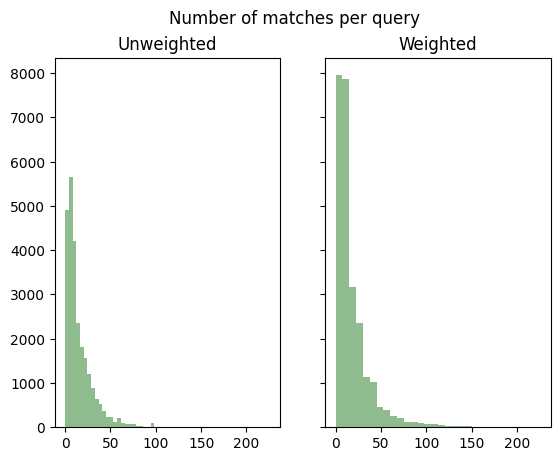

In [7]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

# Plot number of matches per query
num_matches = queries.library_spectra_matches.apply(lambda x: len(x))
ax1.hist(num_matches, bins=30, color='darkseagreen')
ax1.set_title('Unweighted')

# Plot number of matches per weighted query
num_matches = weighted_queries.library_spectra_matches.apply(lambda x: len(x))
ax2.hist(num_matches, bins=30, color='darkseagreen')
ax2.set_title('Weighted')

# Show plot
plt.suptitle('Number of matches per query')
plt.show()

# Look at exact matches

### Look at ranks of exact matches

In [8]:
# Get all ranks of exact matches
all_ranks = list(itertools.chain(*list(queries['exact_matches'])))
all_ranks_weighted = list(itertools.chain(*list(weighted_queries['exact_matches'])))

# Get highest rank of exact matches for each query
all_rank_1 = [x[0] for x in queries['exact_matches'] if len(x) > 0]
all_rank_1_weighted = [x[0] for x in weighted_queries['exact_matches'] if len(x) > 0]

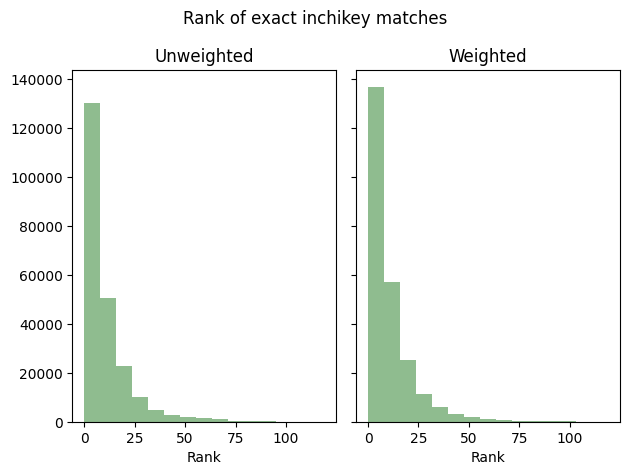

Median unweighted rank:  6.0
Median weighted rank:  6.0


In [9]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot rank of exact matches
_,bins,_ = ax1.hist(all_ranks, bins=15, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlabel('Rank')

# Plot rank of exact matches for weighted queries
ax2.hist(all_ranks_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
#plt.savefig('../figures/rank_modified_cosine.png', dpi=400)
plt.show()

print('Median unweighted rank: ', np.median(all_ranks))
print('Median weighted rank: ', np.median(all_ranks_weighted))

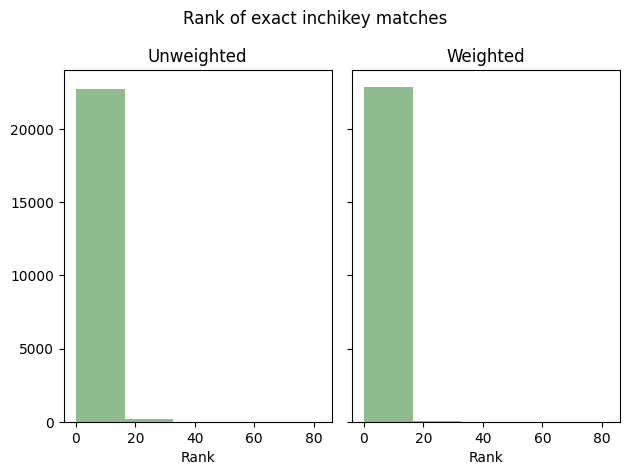

Median unweighted top rank:  0.0
Median weighted top rank:  0.0


In [10]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot highest rank of exact matches
_,bins,_ = ax1.hist(all_rank_1, bins=5, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlabel('Rank')

# Plot highest rank of exact matches for weighted queries
ax2.hist(all_rank_1_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
plt.show()

print('Median unweighted top rank: ', np.median(all_rank_1))
print('Median weighted top rank: ', np.median(all_rank_1_weighted))

#### Look at the percent of queries with an exact match in the top n matches

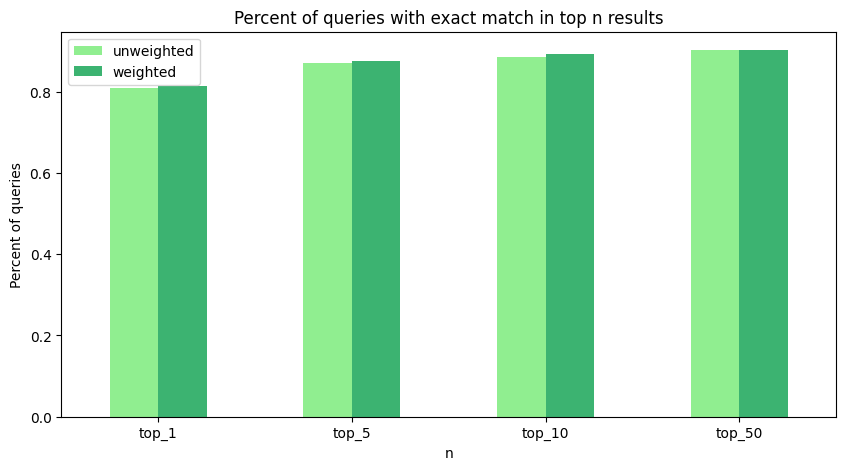

In [11]:
# Create data frame
exact_matches_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                   index=['top_1', 'top_5', 'top_10', 'top_50'])
n_vals = [1, 5, 10, 50]

# Get percent of queries with exact match in top 5
for n in n_vals:
    exact_matches_top_n.loc[f'top_{n}', 'unweighted'] = queries.loc[queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / queries.shape[0]
    exact_matches_top_n.loc[f'top_{n}', 'weighted'] =  weighted_queries.loc[weighted_queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / weighted_queries.shape[0]

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen', 'darkgreen'])
plt.title('Percent of queries with exact match in top n results')
plt.ylabel('Percent of queries')
plt.xlabel('n')
plt.show()


# Non-exact match retrival

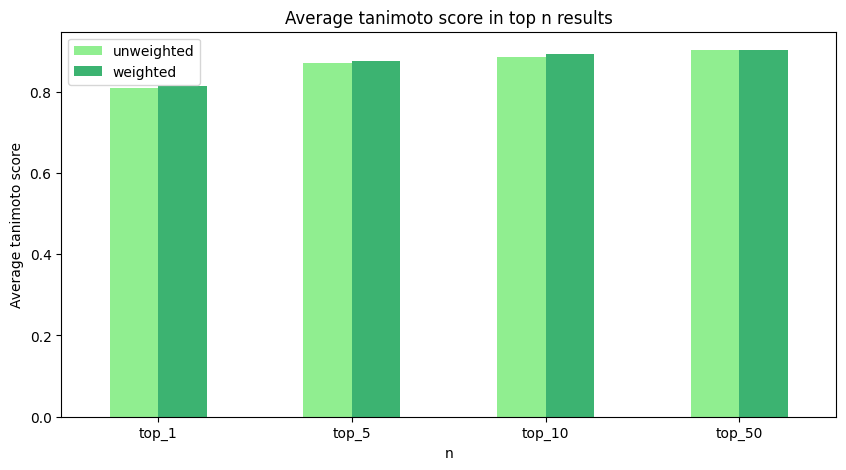

In [12]:
# Create data frame
average_tanimoto_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                      index=['top_1', 'top_5', 'top_10'])
n_vals = [1, 5, 10]

# Calculate average tanimoto score for top n results
for i in n_vals:
    average_tanimoto_top_n.loc['unweighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in queries['tanimoto'] if len(x) > 0])))
    average_tanimoto_top_n.loc['weighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in weighted_queries['tanimoto'] if len(x) > 0])))

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen', 'darkgreen'])
plt.title('Average tanimoto score in top n results')
plt.ylabel('Average tanimoto score')
plt.xlabel('n')
plt.show()

# Look at AUC scores

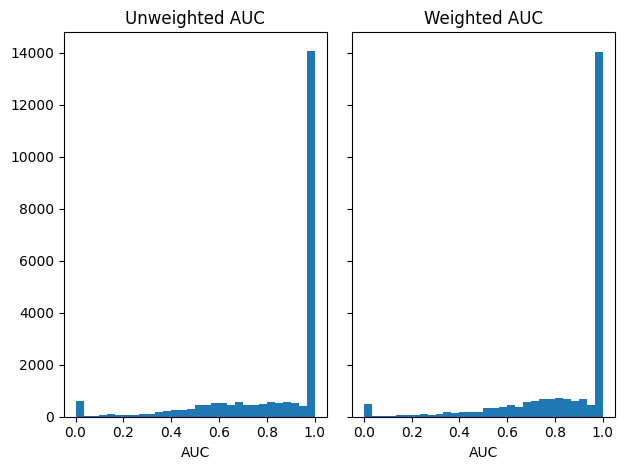

In [13]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot AUC scores for queries
ax1.hist(queries[f'auc'], bins=30)
ax1.set_title(f'Unweighted AUC')
ax1.set_xlabel('AUC')

# Plot AUC scores for weighted queries
ax2.hist(weighted_queries[f'auc'], bins=30)
ax2.set_title(f'Weighted AUC')
ax2.set_xlabel('AUC')

# Show plot
plt.tight_layout()
plt.show()

In [14]:
# number of NaNs in 'auc' column
print(f'Length of queries: {len(queries)}')
print('Number of NaNs in queries: ', len(queries[queries['auc'].isnull()]))
print('Number of NaNs in weighted_queries: ', len(weighted_queries[weighted_queries['auc'].isnull()]))


Length of queries: 25437
Number of NaNs in queries:  1994
Number of NaNs in weighted_queries:  2045
